In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [0]:
contentPath = 'drive/My Drive/Colab Notebooks/StyleTransfer/contentLisa.jpg'
stylePath = 'drive/My Drive/Colab Notebooks/StyleTransfer/styleNight.jpg'

# Image Helper Functions
These functions help us interact with images

In [0]:
def load_image(image_path):
  max_width = 512
  img = Image.open(image_path)
  img = img.resize((max_width, round(max_width/img.size[0]*img.size[1])))
  img = img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  return img

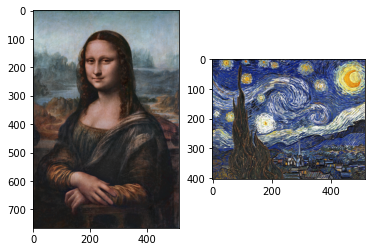

In [56]:
contentImg = load_image(contentPath)
styleImg = load_image(stylePath)
contentImg = contentImg.astype('uint8')
styleImg = styleImg.astype('uint8')
contentImg = np.squeeze(contentImg, axis = 0)
styleImg = np.squeeze(styleImg, axis = 0)

plt.subplot(1,2,1)
plt.imshow(contentImg)

plt.subplot(1,2,2)
plt.imshow(styleImg)

plt.show()

In [0]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py#L21
def process_image(image_path):
  img = load_image(image_path)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_image(image):
  image = np.squeeze(image, axis = 0)
  mean = [103.939, 116.779, 123.68]
  image[:, :, 0] += 103.939
  image[:, :, 1] += 116.779
  image[:, :, 2] += 123.68
  image = image[:, :, ::-1]

  image = image.astype('uint8')
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


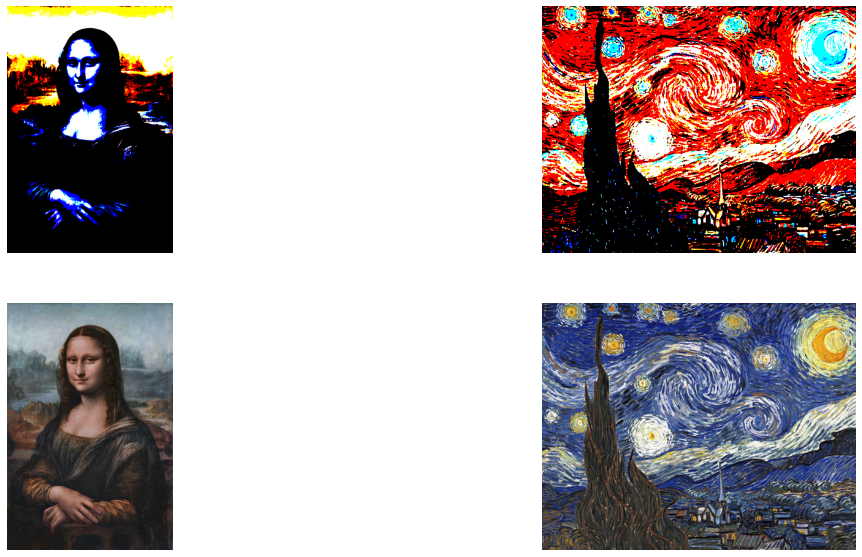

In [59]:
content = process_image(contentPath)
style = process_image(stylePath)
content1 = content
style1 = style
content1 = np.squeeze(content, axis = 0)
style1 = np.squeeze(style, axis = 0)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.axis('off')
ax1.imshow(content1)

ax3.axis('off')
ax3.imshow(deprocess_image(content))

ax2.axis('off')
ax2.imshow(style1)

ax4.axis('off')
ax4.imshow(deprocess_image(style))

plt.show()

# Settng up VGG19 Model

In [0]:
from tensorflow.python.keras import models

In [0]:
layers = ['block1_conv1',
          'block2_conv1',
          'block3_conv1',
          'block4_conv1',
          'block5_conv1']

In [0]:
def get_Model():
  model = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')
  outputs = [model.get_layer(name).output for name in layers]
  model = models.Model(model.input, outputs)
  for layer in model.layers:
    layer.trainable = False
  return model

# Getting dem features

In [0]:
def get_features(image, model):
  output = model(image)
  features = [layer[0] for layer in output]
  return features

In [0]:
def gram_matrix(tensor):
  channels = tensor.shape[-1]
  a = tf.reshape(tensor, [-1, channels])
  n = a.shape[0]
  gram = tf.matmul(a, a, transpose_a = True)
  #return gram 
  return gram / tf.cast(n, tf.float32)

In [0]:
# this one
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a = True)
  return gram / tf.cast(n, tf.float32)

# Loss

In [0]:
def get_style_loss(image_features, style_features):
  style_loss = 0
  style_weights = [1.0, 0.8, 0.5, 0.3, 0.1]
  weight_per_style_layer = 1.0 / 5.0
  for w in range(len(style_weights)):
    gram_image = gram_matrix(image_features[w])
    gram_style = gram_matrix(style_features[w])
    style_loss += style_weights[w] * tf.reduce_mean(tf.square(gram_image - gram_style))
  return style_loss

In [0]:
def get_content_loss(content_features, image_features, content_weight):
  3
  content_loss = tf.reduce_mean(tf.square(image_features[4] - content_features[4]))
  content_loss *= content_weight
  return content_loss


In [0]:
def get_loss(content_features, image_features, content_weight, style_features):
  content = get_content_loss(content_features, image_features, content_weight)
  style = get_style_loss(image_features, style_features)
  print("content:", content, "style:", style)
  return content + style

In [0]:
def get_newgradient(image, content_features, image_features, content_weight, style_features):
  with tf.GradientTape() as tape:
    loss = get_loss(content_features, image_features, content_weight, style_features)
  print("newgradient_loss:", loss)
  grad = tape.gradient(loss, image)
  return grad

In [0]:
def get_gradient(content, image, style, model):
  optimizer = tf.keras.optimizers.Adam(learning_rate = 5)
  with tf.GradientTape() as tape:
    tape.watch(image)
    image_features = get_features(image, model)
    style_features = get_features(style, model)
    content_features = get_features(content, model)
    content_loss = tf.reduce_mean(tf.square(image_features[3]-content_features[3]))
    content_loss = 0

    style_loss = 0
    # style_weights = [1.0, 0.8, 0.5, 0.3, 0.1]
    style_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    for w in range(len(style_weights)):
      gram_image = gram_matrix(image_features[w])
      gram_style = gram_matrix(style_features[w])
      # style_loss += style_weights[w] * tf.reduce_mean(tf.square(gram_image - gram_style))
      style_loss += style_weights[w] * tf.reduce_mean(tf.square(gram_style - gram_image))
    loss = style_loss + content_loss
  grad = tape.gradient(loss, image)
  # print("gradient_loss:", grad)
  optimizer.apply_gradients([(grad, image)])
  return image, loss

# Training

In [0]:
def train(content_path, style_path, content_weight = 1):
  content = process_image(content_path)
  style = process_image(style_path)
  image = process_image(content_path)
  image = tf.Variable(image, dtype = tf.float32)

  model = get_Model()

  content_features = get_features(content, model)
  style_features = get_features(style, model)

  # optimizer = tf.keras.optimizers.Adam(learning_rate = 5)
  steps = 1000

  print("Starting Training")
  for i in range(steps):
    # features
    '''
    image_features = get_features(image, model)

    
    # loss
    content_loss = tf.reduce_mean(tf.square(image_features[3]-content_features[3]))
    content_loss *= content_weight
    
    style_loss = 0
    style_weights = [1.0, 0.8, 0.5, 0.3, 0.1]
    for w in range(len(style_weights)):
      gram_image = gram_matrix(image_features[w])
      gram_style = gram_matrix(style_features[w])
      style_loss += style_weights[w] * tf.reduce_mean(tf.square(gram_image - gram_style))

    print("content_loss: ", content_loss, "style_loss: ", style_loss)
    loss = content_loss + style_loss
    '''
    
    image, loss = get_gradient(content, image, style, model)


    # image, loss = get_gradient(content, image, style, model)
    # newgrad = get_newgradient(image, content_features, image_features, content_weight, style_features)
    # print("grad:", grad, "newgrad:", newgrad)
    #optimizer.apply_gradients([(grad, image)])

    best_loss = float('inf')
    # loss = content_loss + style_loss
    if loss < best_loss:
      bestLoss = loss
      bestImage = deprocess_image(image.numpy())

    if i % 100 == 0:
      print("step#", i, '/', steps)

  
  return bestImage

# Final Output

In [88]:
final = train(contentPath, stylePath)

Starting Training
step# 0 / 1000
step# 100 / 1000
step# 200 / 1000
step# 300 / 1000
step# 400 / 1000
step# 500 / 1000
step# 600 / 1000
step# 700 / 1000
step# 800 / 1000
step# 900 / 1000


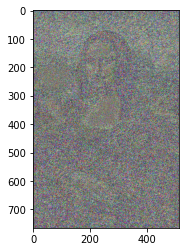

In [89]:
plt.imshow(final)